# Super Simple Keras model on TriFeature for multiplicity determination

In [1]:
label = "nPH"
nmax = 4

In [2]:
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

sys.path.append("..")
from helpers import tridata

In [3]:
import tensorflow
from tensorflow import keras

print("tensorflow", tensorflow.__version__)
print("keras", keras.__version__)

tensorflow 2.3.1
keras 2.4.0


In [4]:
traindata, testdata = tridata(distance=15, doubleplane=30, energy=600, erel=500, nmax=nmax, physics="inclxx")
print(traindata.shape, testdata.shape)

x_train = traindata[["nHits", "nClus", "Edep"]].values
y_train = keras.utils.to_categorical(traindata[[label]].values.ravel())

x_val = testdata[["nHits", "nClus", "Edep"]].values
y_val = keras.utils.to_categorical(testdata[[label]].values.ravel());

(640267, 6) (159733, 6)


In [5]:
models = defaultdict(keras.models.Sequential)

models["(SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

models["(10, SM)"].add(keras.layers.Dense(units=10, activation="relu"))
models["(10, SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

models["(20, SM)"].add(keras.layers.Dense(units=20, activation="relu"))
models["(20, SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

models["(100, SM)"].add(keras.layers.Dense(units=100, activation="relu"))
models["(100, SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

models["(100, 10, SM)"].add(keras.layers.Dense(units=100, activation="relu"))
models["(100, 10, SM)"].add(keras.layers.Dense(units=10, activation="relu"))
models["(100, 10, SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

optimizer = keras.optimizers.Adam
loss = keras.losses.CategoricalCrossentropy

histories = {}
for name, model in models.items():
    print(name)
    model.compile(loss=loss(), optimizer=optimizer(), metrics=["accuracy"])
    histories[name] = model.fit(
        x=x_train, y=y_train, batch_size=1000, epochs=50, validation_data=(x_val, y_val), verbose=2
    )
    print("----")

(SM)
Epoch 1/50
641/641 - 1s - loss: 22.2780 - accuracy: 0.2613 - val_loss: 3.5496 - val_accuracy: 0.2922
Epoch 2/50
641/641 - 1s - loss: 2.6533 - accuracy: 0.3233 - val_loss: 1.7529 - val_accuracy: 0.3728
Epoch 3/50
641/641 - 2s - loss: 1.2899 - accuracy: 0.4494 - val_loss: 1.0768 - val_accuracy: 0.5090
Epoch 4/50
641/641 - 2s - loss: 1.0240 - accuracy: 0.6266 - val_loss: 0.9873 - val_accuracy: 0.6979
Epoch 5/50
641/641 - 1s - loss: 0.9557 - accuracy: 0.6852 - val_loss: 0.9209 - val_accuracy: 0.7592
Epoch 6/50
641/641 - 1s - loss: 0.8998 - accuracy: 0.7216 - val_loss: 0.8715 - val_accuracy: 0.7202
Epoch 7/50
641/641 - 1s - loss: 0.8541 - accuracy: 0.7301 - val_loss: 0.8405 - val_accuracy: 0.7597
Epoch 8/50
641/641 - 1s - loss: 0.8144 - accuracy: 0.7413 - val_loss: 0.7932 - val_accuracy: 0.7856
Epoch 9/50
641/641 - 1s - loss: 0.7788 - accuracy: 0.7557 - val_loss: 0.7750 - val_accuracy: 0.6791
Epoch 10/50
641/641 - 1s - loss: 0.7493 - accuracy: 0.7575 - val_loss: 0.7331 - val_accuracy: 

In [6]:
x_test = testdata[["nHits", "nClus", "Edep"]].values
y_true = testdata[[label]].values.ravel()

for name, model in models.items():
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    bac = balanced_accuracy_score(y_true, y_pred)
    print(name, bac)

(SM) 0.8286242228506977
(10, SM) 0.829596528899
(20, SM) 0.8223383692737679
(100, SM) 0.8262587115811562
(100, 10, SM) 0.8189747646158569


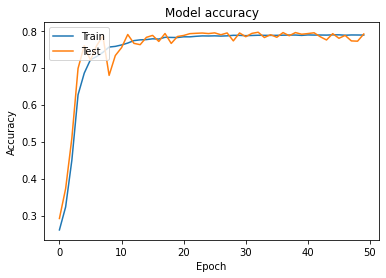

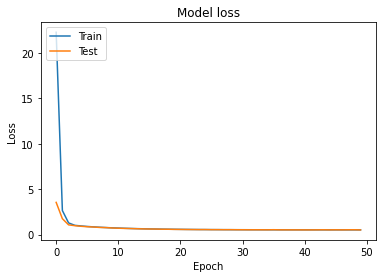

In [7]:
history = histories["(SM)"]

# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

In [8]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

y_pred = models["(20, SM)"].predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1), normalize="true")
print(cmrel)

0.8223383692737679
[[ 2084     1     0     1     0]
 [    0 39646  2388    13     6]
 [    0  4515 28805  8446    13]
 [    0   196  5090 32057  3785]
 [    0     6   321  9447 22913]]
[[0.999 0.    0.    0.    0.   ]
 [0.    0.943 0.057 0.    0.   ]
 [0.    0.108 0.689 0.202 0.   ]
 [0.    0.005 0.124 0.779 0.092]
 [0.    0.    0.01  0.289 0.701]]
